## A decision support system for Risk assessment
Model Selection
I am going to compare the best feature based on eye movements for predicting risk assesment. 

The data are from 32 subjects who watched 20 driving clips. Each row identify a period of 1 second within trials. Subjects identified with a button press those moments where they thought the car should brake. Data include evenly windows before and independent of subject's report.

Variables included are:

1) A Risk status: positive or negative.

2) Demographic variables: age, race, gender.

3) Eye movement variables: Saccadic magnitude, number of fixations, fixation duration, dispersion in x, dispersion in y, number of blinks, pupil size

Below I'll test three best pairs of features.

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import operator
import statsmodels.api as sm
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import warnings
#warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [32]:
# read the data, create at copy
df0 = pd.read_csv('/Users/FranciscoCostela/Desktop/Risk/risk.csv')
df1 = pd.DataFrame.copy(df0)

df1.dropna()
# remove rows with NaNs
for index, row in df1.iterrows():
    if any([np.isnan(i) for i in row.values]):
        df1.drop(index, inplace=True)
    if any([i== np.Infinity for i in row.values]):
        df1.drop(index, inplace=True)
   
# remove outliers
df1.drop(df1[df1['magsac'] > 20].index, inplace = True) 
df1.drop(df1[df1['nusacs'] > 9].index, inplace = True) 
df1.drop(df1[df1['pupincrease'] > 100].index, inplace = True) 
df1.drop(df1[df1['fixdur'] =='.'].index, inplace = True) 

# reindex
df1.index = range(len(df1))

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331 entries, 0 to 1330
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1331 non-null   int64  
 1   trial        1331 non-null   int64  
 2   vidnum       1331 non-null   int64  
 3   nsacs        1331 non-null   int64  
 4   magsac       1331 non-null   float64
 5   nusacs       1331 non-null   int64  
 6   magusacs     1331 non-null   float64
 7   nfixs        1331 non-null   int64  
 8   fixdur       1331 non-null   float64
 9   disperx      1331 non-null   float64
 10  dispery      1331 non-null   float64
 11  nblinks      1331 non-null   int64  
 12  pupincrease  1331 non-null   float64
 13  risk         1331 non-null   int64  
 14  age          1331 non-null   float64
 15  male         1331 non-null   int64  
dtypes: float64(7), int64(9)
memory usage: 166.5 KB


/Users/FranciscoCostela/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### Univariate analysis
Feature histograms.
First we can look at how each variable is distributed within the dataset.

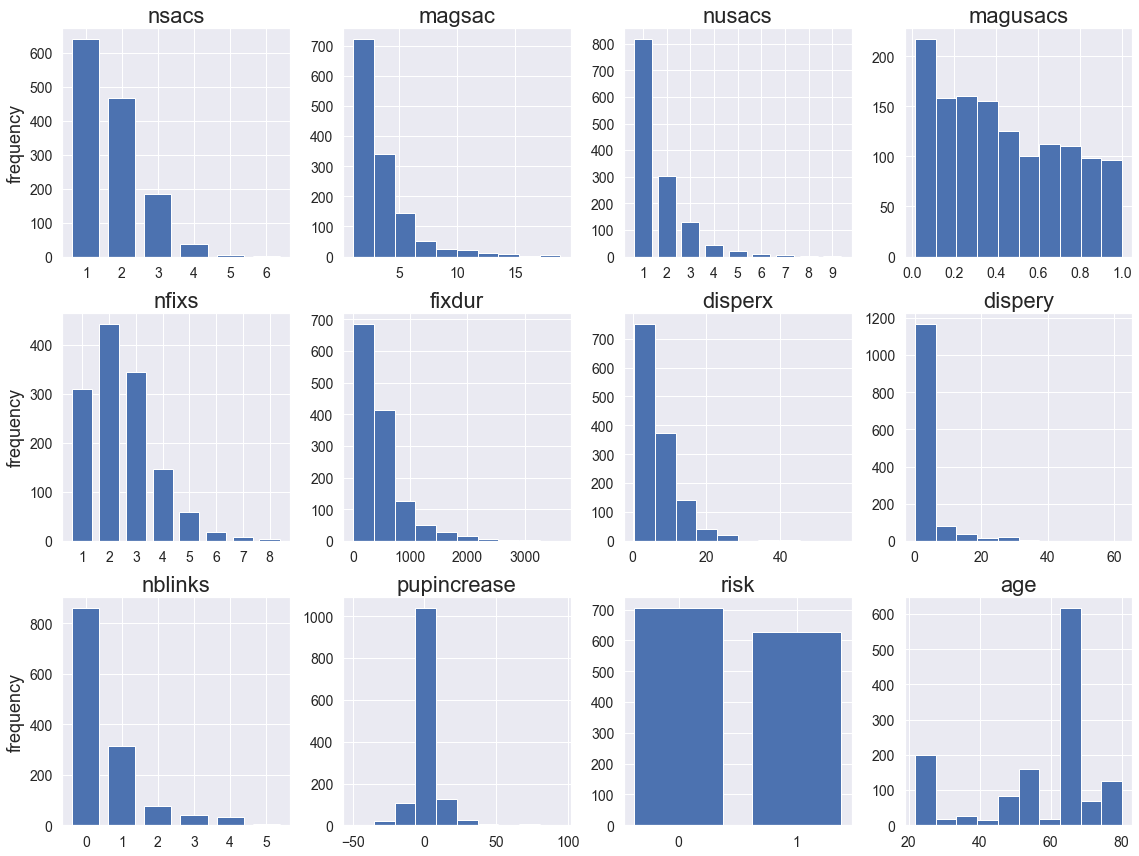

In [31]:

plt.figure(figsize = (16,12))

# get bins for discrete variables
def bin_edges(u): 
    u = sorted(u)
    d = (u[1] - u[0])
    edges = u - d/2
    edges = np.append(edges, edges[-1]+d)
    return edges

sp = 1     
values = df1.keys().values
for key in values[3:15]:
    plt.subplot(3, 4, sp)
    if len(df1[key].unique()) < 10:
        plt.hist(df1[key], bins=bin_edges(df1[key].unique()), rwidth=.75)
        plt.xticks(sorted(df1[key].unique()))
    else:    
        plt.hist(df1[key])
    if sp in [1, 5, 9]:
        plt.ylabel('frequency', fontsize=18)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.title(key, fontsize=22)
    sp = sp + 1
plt.tight_layout()
plt.show()

### Joint feature/diagnosis histograms
Next we can look at how predictive each variable is of a positive diagnosis.

We'll start by plotting 2D histograms with each variable as a function of diagnosis.

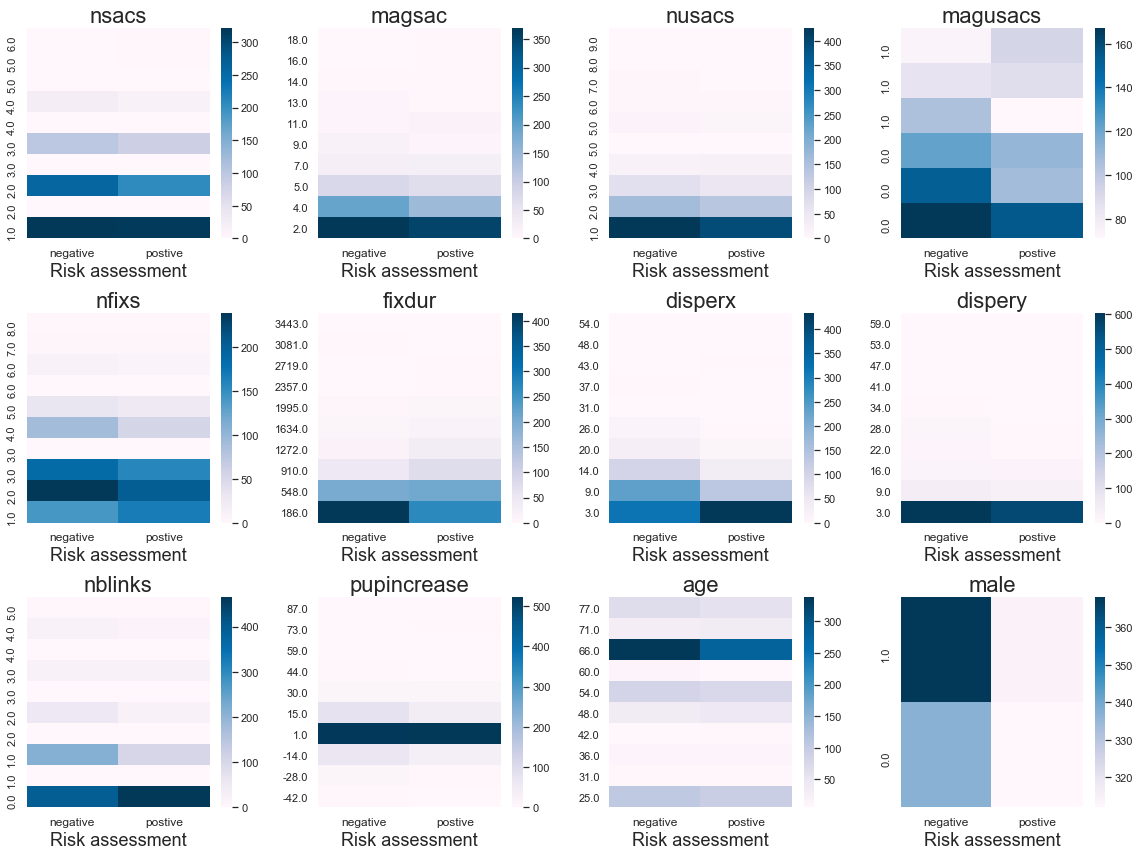

In [33]:
# look at joint histograms  - each as a function of Risk

# get bin centers from edge array
def bin_centers(a): 
    return a[:-1] + (a[1] - a[0])/2

# better bins for the variables
bins = {'risk': 2,
        'age': 10,        
        'male': 2,
        'nsacs': 10,
        'magsac': 10,
        'nusacs': 10,
        'magusacs': 6,
        'nblinks': 10,
        'nfixs': 10,
        'fixdur': 10,
        'disperx': 10,
        'dispery': 10,
        'pupincrease':10}

# create dict for result
H2d = dict.fromkeys(df1.keys())
H2d.pop('risk')
H2d.pop('id')
H2d.pop('trial')
H2d.pop('vidnum')

plt.figure(figsize = (16,12))
sp = 1
for key in H2d.keys():
    H2d[key] = np.histogram2d(df1[key], df1['risk'], bins=(bins[key], bins['risk'] ))
    ax = plt.subplot(3, 4, sp)
    r = 0
    ytlabels = np.round(bin_centers(H2d[key][1][::-1]), r)
    sns.heatmap(np.flipud(H2d[key][0]), cmap='PuBu', ax=ax, annot=False, 
                yticklabels=ytlabels, xticklabels=['negative', 'postive'])
    ax.set_xlabel('Risk assessment', size=18)
    ax.set_title(key, size=22)
    sp = sp + 1
    #plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

The features do not diverge substantially between risk assessments. Apparently better candidates may be fixdur, magsac, nblinks, and disperx

### Correlation

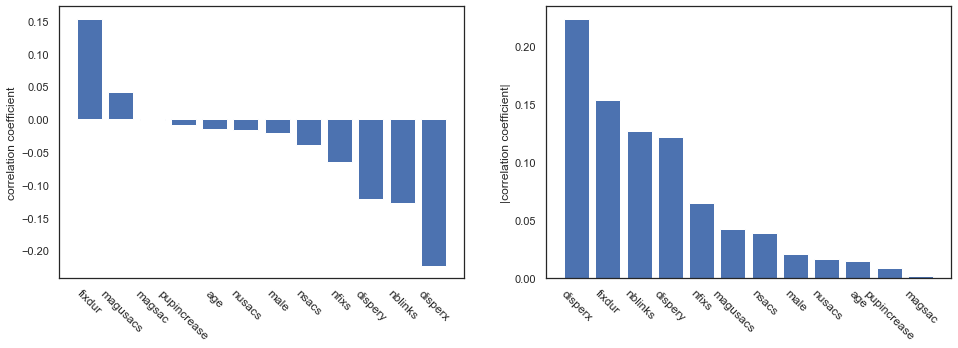

In [34]:
# correlate each one with hazard perception
Xvars = df1.keys().values[1:]
Y = df1['risk']

R = dict([(key,0) for key in H2d])
P = dict([(key,0) for key in H2d])

for key in H2d.keys():
    r, p = stats.pointbiserialr(df1[key], Y)
    R[key] = r
    P[key] = p

# get absolute value of the correlations and sort    
R_abs = dict([(key, abs(item)) for key, item in R.items()]) 
R_sort = list(zip(*sorted(R.items(), key=operator.itemgetter(1), reverse=True)))
R_sort_abs = list(zip(*sorted(R_abs.items(), key=operator.itemgetter(1), reverse=True)))

# plot corrs
sns.set_style('white')
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
plt.bar(range(len(R_sort[1])), R_sort[1])
plt.xticks(range(len(R_sort[1])), R_sort[0], rotation=-45, fontsize=12 )
plt.ylabel('correlation coefficient', fontsize=12)

# plot abs corrs
ax2 = fig.add_subplot(1,2,2)
plt.bar(range(len(R_sort_abs[1])), R_sort_abs[1])
plt.xticks(range(len(R_sort_abs[1])), R_sort_abs[0], rotation=-45, fontsize=12 )
plt.ylabel('|correlation coefficient|', fontsize=12)

plt.show()

Disperx, Fixdur, Nblinks and Dispery have the highest magnitude correlations with diagnoses.

### Logistic Regression

In [35]:
# logistic regression
def do_log_reg(IV, DV):
    IV = IV.tolist()
    DV = DV.tolist()
    IN = np.ones((len(IV),1))
    X = np.column_stack((IV, IN))
    logit = sm.Logit(DV, X)
    return(logit.fit(disp=0))

result = {}

# logistic regression for the continuous variables
for key in H2d.keys():
    result[key] = do_log_reg(df1[key], df1['risk'])
    print('{}: params = {}, \n\tp = {}, \n\tr2 = {}\n'.format(key, result[key].params, 
                                                                   result[key].pvalues, 
                                                                   result[key].prsquared))
# chi2 tests for the discrete variables                                                                      
for key in ['male']:
    result[key] = stats.chi2_contingency(H2d[key][0])
    print('{}: chi2 = {}, \n\tp = {}\n'.format(key, result[key][0], result[key][1]))

nsacs: params = [-0.09372173  0.0428802 ], 
	p = [0.15479773 0.73379821], 
	r2 = 0.0011051453536818912

magsac: params = [-0.00124289 -0.11464985], 
	p = [0.95431505 0.21051492], 
	r2 = 1.7836770307422256e-06

nusacs: params = [-0.03078757 -0.06762993], 
	p = [0.54021659 0.49876987], 
	r2 = 0.00020442989134106249

magusacs: params = [ 0.29643607 -0.24804103], 
	p = [0.12276368 0.01334818], 
	r2 = 0.001295591468716717

nfixs: params = [-0.10576709  0.14246044], 
	p = [0.01808184 0.24738761], 
	r2 = 0.0030705400296064944

fixdur: params = [ 0.00079275 -0.50031943], 
	p = [6.94123137e-08 1.71140575e-08], 
	r2 = 0.01758512246538957

disperx: params = [-0.09807381  0.52990397], 
	p = [4.85376296e-15 4.48090663e-08], 
	r2 = 0.04055594807349727

dispery: params = [-0.04909723  0.04794046], 
	p = [2.29798598e-05 4.70681546e-01], 
	r2 = 0.011582857900186538

nblinks: params = [-0.28196671  0.03439817], 
	p = [5.56312289e-06 5.90743307e-01], 
	r2 = 0.012052416013838219

pupincrease: params = [-0

This is giving us information similar to the correlations:

Nfixs, fixdur, disperx, dispery, nblinks have significant tests

Disperx has relatively higher $r^2$ values than the rest. The first parameter value is the regression slope which gives an indication of how the probability of a positive risk assesment changes with a unit change in the variable. Nblinks and Nfixs have an absolute slope bigger than the rest of features indicating that they may be a more sensitive indicator.

### Summary so far
Age and gender will likely not be useful due their non-representative distributions and low correlations with risk assesment.
Disperx and fixdur are most predictive followed by nblinks and dispery. These are our best candidates for inclusion into a predictive model.
In order to find the best combination of these variables, we need to consider the degree to which they're correlated with each other. We'll do that below.

### Joint feature/feature comparisons
First we'll calculate the correlation of each feature with the other features.

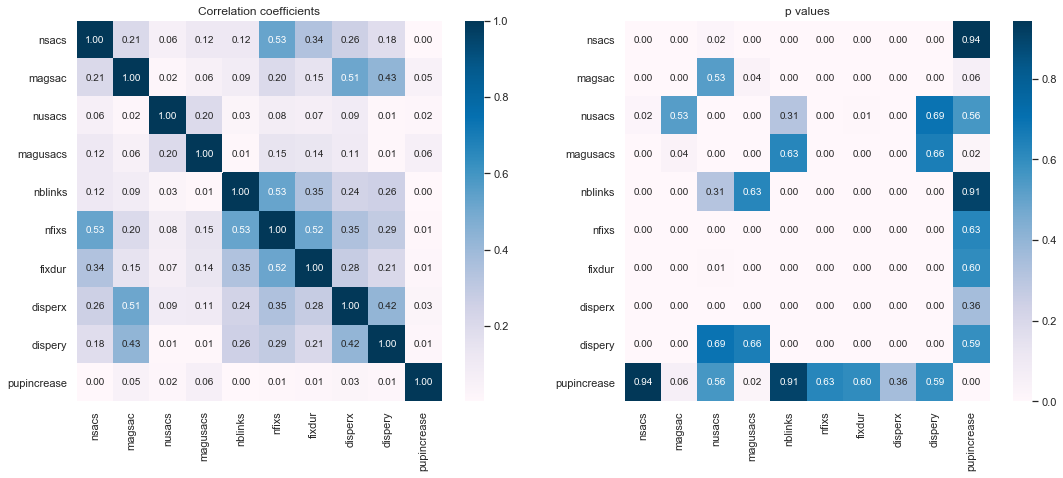

In [36]:
# get independent variables
Xvars = ['nsacs','magsac','nusacs','magusacs','nblinks','nfixs','fixdur','disperx','dispery','pupincrease']

R = np.zeros([len(Xvars), len(Xvars)])
P = np.zeros([len(Xvars), len(Xvars)])

# do point biserial correlation for dicho/cont variables
for i in range(len(Xvars)):
    for j in range(len(Xvars)):
        r, p = stats.pointbiserialr(df1[Xvars[i]], df1[Xvars[j]])
        R[i][j] = r
        P[i][j] = p

# plot
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,2, 1)
sns.heatmap(abs(R), annot=True, fmt=".2f", xticklabels=Xvars, yticklabels=Xvars, cmap='PuBu', ax=ax1)
plt.title('Correlation coefficients')

ax2 = fig.add_subplot(1,2,2)
sns.heatmap(P, annot=True, fmt=".2f", xticklabels=Xvars, yticklabels=Xvars, cmap='PuBu', ax=ax2)
plt.title('p values')

plt.show()

Nfixs is highly correlated with Nsaccs, nblinks, and fixdur
Due to their high degree of multicolinearity, including nfixs in the predictive model may produce results that are misleading in terms of the relative importance placed on each variable in predicting the assessment.

However, it may possible to find optimal combinations of the variables that are more sensitive predictors than each variable alone. 


In [111]:
# leave-one-out CV
def cv_loo(X, Y, model):
    y_pred = []
    p_pred = np.empty((0,2))
    for i in range(X.shape[0]):      
        ind = list(range(X.shape[0]))
        ind_tr = [j for j in ind if j != i]
        ind_te = i
        if X.shape[1] > 1:
            X_train = X[ind_tr, :]
            X_test = X[i, :]
        else:    
            X_train = X[ind_tr]
            X_test = X[i]
        Y_train = Y[ind_tr]
        Y_test = Y[i]
        model.fit(X_train, Y_train)
        y_pred.append(model.predict([X_test]))
        p_pred = np.vstack([p_pred,model.predict_proba([X_test])])
    result = {'y_pred': np.array(y_pred), 'y_true': Y, 'p_pred': p_pred}
    return result

# model performance
def results(y_test, y_pred, display):
    # accuracy, hits, true_negatives, misses, false_positives
    acc = sum(y_test == y_pred)/len(y_test)
    tpos = sum((y_test == 1) & (y_pred==1))/sum(y_test == 1)
    tneg = sum((y_test == 0) & (y_pred==0))/sum(y_test == 0)
    fneg = sum((y_test == 1) & (y_pred==0))/sum(y_test == 1)
    fpos = sum((y_test == 0) & (y_pred==1))/sum(y_test == 0)
    if display:
        # print the results
        print('accuracy = %.3f' % acc)
        print('hits = %.3f' % tpos)
        print('misses = %.3f' % fneg)
        print('true negatives = %.3f' % tneg)
        print('false positives = %.3f' % fpos)
    # save the results
    return {'acc': acc, 'tpos': tpos, 'tneg': tneg, 'fneg': fneg, 'fpos': fpos}


Applying to different combinations of features

In [112]:
d_prime = lambda h,f: norm.ppf(h) - norm.ppf(f)

features = [['nfixs', 'disperx'],
            ['nfixs', 'dispery'],
            [ 'nfixs','disperx', 'dispery', 'nblinks']]
Y = df0['risk'].values
dp = []
acc = []
hits= []
fps = []
probs = {}
for feature in range(len(features)):
    X = df0[features[feature]].values
    model = LogisticRegression()
    cv_result = cv_loo(X, Y, model)
    result = results(cv_result['y_true'], np.ravel(cv_result['y_pred']), False)
    acc.append(result['acc'])
    hits.append(result['tpos'])
    fps.append(result['fpos'])
    dp.append(d_prime(result['tpos'], result['fpos']))
    probs[feature] = cv_result['p_pred']

    
data = np.array([acc, hits, fps, dp]).T;
index = [' | '.join(f) for f in features]
columns = ['accuracy', 'Hits', 'FP', 'd\'']
table = pd.DataFrame(data, columns = columns, index = index)
table.head()



,accuracy,Hits,FP,d'
nfixs | disperx,0.600267,0.729432,0.531685,0.531590
nfixs | dispery,0.564473,0.677079,0.550562,0.332465
nfixs | disperx | dispery | nblinks,0.609604,0.738671,0.522247,0.583460


##  Random Forest Classifier 

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       690
           1       0.65      0.61      0.63       660

    accuracy                           0.65      1350
   macro avg       0.65      0.65      0.65      1350
weighted avg       0.65      0.65      0.65      1350

MAE: 0.35185185185185186
MSE: 0.35185185185185186
RMSE: 0.5931710140017395
[[472 218]
 [257 403]]


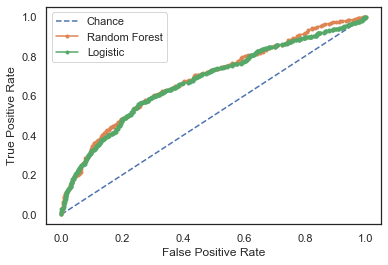

In [99]:
feats = [ 'nfixs','disperx', 'dispery', 'nblinks']
x = df0[feats]
y = df0['risk']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rfc_preds = rfc.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,rfc_preds))
print('MAE:', metrics.mean_absolute_error(y_test, rfc_preds))
print('MSE:', metrics.mean_squared_error(y_test, rfc_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,rfc_preds)))
print(confusion_matrix(y_test,rfc_preds))
x.columns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
ns_probs = [0 for _ in range(len(y_test))]
fpr2, tpr2, threshold = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Chance')
pyplot.plot(fpr2, tpr2, marker='.', label='Random Forest')
pyplot.plot(fplo, tplo, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
nfixs = tf.feature_column.numeric_column("nfixs")
disperx = tf.feature_column.numeric_column('disperx')
dispery = tf.feature_column.numeric_column('dispery')
nblinks =tf.feature_column.numeric_column('nblinks')
fixdur = tf.feature_column.numeric_column('fixdur')
feat_cols = [nfixs, disperx, dispery, nblinks, fixdur]
classifier = tf.estimator.DNNClassifier(hidden_units=[10, 20, 10], n_classes=2,feature_columns=feat_cols)

## Neural network

Define a neural network with 3 hidden layers: 2 rectified linear units and one sigmoid (this is a binary classification problem)

In [83]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


The below code compiles the network. It uses Adam, a momentum-based optimizer. The loss function used is binary_crossentropy. For binary classification problems that give output in the form of probability, binary_crossentropy is usually the optimizer of choice. mean_squared_error may also be used instead of binary_crossentropy as well. Metrics used is accuracy. The model is trained for 50 epochs with a batch size of 1. Finally, the trained model was evaluated for the test set to check the accuracy.

In [84]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

Train on 3148 samples
Epoch 1/50
3148/3148 [==============================] - 4s 1ms/sample - loss: 0.6840 - accuracy: 0.60861s - loss: 0.6950 -  -
Epoch 2/50
3148/3148 [==============================] - 3s 1ms/sample - loss: 0.6461 - accuracy: 0.64933s - ETA: 2s - loss: 0.6669 - accuracy: 0. - ETA: 2s - loss: 0.6614 - accuracy:  - ETA: 2s -
Epoch 3/50
3148/3148 [==============================] - 3s 988us/sample - loss: 0.6356 - accuracy: 0.6518: 1s - loss: 0.6370 -  - ETA: 0s - los
Epoch 4/50
3148/3148 [==============================] - 3s 1ms/sample - loss: 0.6333 - accuracy: 0.65222s - loss: 0.6309 - accu - ETA: 2s - loss: 0.6293 - accuracy: 0.66 - ETA - ETA: 1s - loss: - ETA: 0s - loss: 0
Epoch 5/50
3148/3148 [==============================] - 3s 1ms/sample - loss: 0.6287 - accuracy: 0.66200s - loss: 0.6239 - accura
Epoch 6/50
3148/3148 [==============================] - 3s 1ms/sample - loss: 0.6278 - accuracy: 0.65692s - loss: 0.6368 - accuracy - ETA: 2s - loss: 0.6374 - accuracy 

0.6111009891827901 0.66074073
              precision    recall  f1-score   support

           0       0.64      0.61      0.63       629
           1       0.68      0.70      0.69       721

    accuracy                           0.66      1350
   macro avg       0.66      0.66      0.66      1350
weighted avg       0.66      0.66      0.66      1350

MAE: 0.33925925925925926
MSE: 0.33925925925925926
RMSE: 0.582459663203607
[[385 244]
 [214 507]]


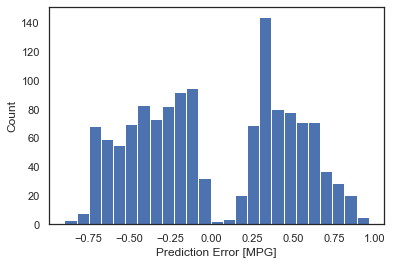

In [87]:
print(test_loss, test_acc)
test_predictions = model.predict(X_test).flatten()

#a = plt.axes(aspect='equal')
#plt.scatter(y_test, test_predictions)
#plt.xlabel('True Values [MPG]')
#plt.ylabel('Predictions [MPG]')

error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")


test_predictions = np.where(test_predictions > 0.5, 1, 0)

print(classification_report(y_test,test_predictions))
print('MAE:', metrics.mean_absolute_error(y_test, test_predictions))
print('MSE:', metrics.mean_squared_error(y_test, test_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_predictions)))

print(confusion_matrix(y_test,test_predictions))
